In [42]:
%matplotlib inline

import catboost
import sys
import glob
sys.path.append('/home/pierre/riken/word2vec')
sys.path.append('/home/pierre/riken/io')

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

import classification_tools
import reader

import matplotlib.pyplot as plt

In [24]:
sns.set(style="darkgrid")

In [36]:
RANDOM_STATE = 42

model_path = '/home/pierre/riken/word2vec/prot_vec_model.model'
data_path = '/home/pierre/riken/data/riken_data/complete_from_xlsx.tsv'
BEST_MODEL_PROPERTIES_PATH = '/home/pierre/riken/data/riken_data/best_model.txt'
CV_OUTPUT_PATH = '/home/pierre/riken/data/riken_data/tree_depth_influence.csv'

K_FOLD = 10
agg_mode = 'sum'

In [37]:
# model = Pipeline([
#     ('ProteinTokenizer', classification_tools.ProteinTokenizer(token_size=3)),
#     ('ProteinVectorization', classification_tools.ProteinW2VRepresentation(model_path=model_path)),
#     ('ClassificationModel', LinearSVC(loss='hinge', dual=True, tol=1e-6))
# ])

# Import Data

In [38]:
df = pd.read_csv(data_path, sep='\t')
df = df.loc[df.seq_len >= 50, :]

X, y = df['sequences'].values, df['is_allergenic'].values

lenghts = df.seq_len.values

In [39]:
featurizing = Pipeline([
    ('ProteinTokenizer', classification_tools.ProteinTokenizer(token_size=3)),
    ('ProteinVectorization', classification_tools.ProteinW2VRepresentation(model_path=model_path, 
                                                                           agg_mode=agg_mode)),
])

X_w2v = featurizing.transform(X)

/home/pierre/miniconda3/envs/python3/lib/python3.6/site-packages/Bio/Seq.py:163: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


In [40]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest, lenghts_train, lenghts_test = train_test_split(X_w2v, y, lenghts, test_size=0.3, 
                                                                             random_state=RANDOM_STATE)

# Dimension reduction & misc

In [13]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA()
pca.fit(X_w2v)
X_pca = pca.transform(X_w2v)

from sklearn.manifold import TSNE

tsne = TSNE(verbose=3, perplexity=50).fit(X_pca)
X_tsne = tsne.embedding_

IncrementalPCA(batch_size=None, copy=True, n_components=None, whiten=False)

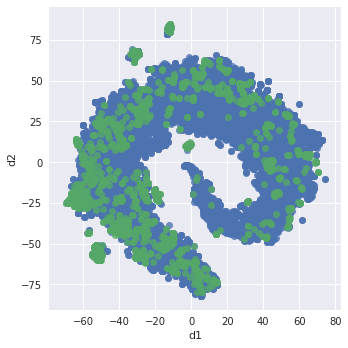

In [35]:
tsne_df = pd.DataFrame({'d1': X_tsne[:, 0], 'd2': X_tsne[:, 1], 'is_allergenic':y})

sns.lmplot(x='d1', y='d2', data=tsne_df, fit_reg=False, hue='is_allergenic', legend=False)

# Checking that W2V rep has a good shape

/home/pierre/.conda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


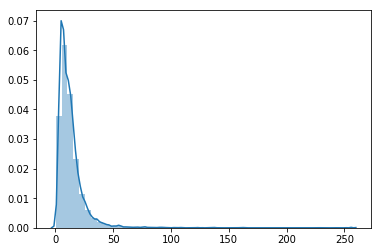

In [7]:
sns.distplot(X_w2v[:, 19])

# Cross Validation SVM

In [ ]:
model = LinearSVC(loss='hinge', dual=True, tol=1e-6, max_iter=50000, class_weight='balanced')
grid = {
    'penalty': ['l2'],
    'C': np.geomspace(start=1e-3, stop=1e2, num=50)
}
cv = GridSearchCV(model, 
                  grid, 
                  scoring=['accuracy', 'precision', 'recall', 'roc_auc'], 
                  refit='roc_auc',
                  cv=StratifiedKFold(n_splits=10),
                  verbose=3)
cv.fit(Xtrain, ytrain)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] C=0.001, penalty=l2 .............................................
[CV]  C=0.001, penalty=l2, accuracy=0.8179871520342612, precision=0.34549356223175964, recall=0.8214285714285714, roc_auc=0.8836203739869155, total=   3.3s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV]  C=0.001, penalty=l2, accuracy=0.7992505353319058, precision=0.3191919191919192, recall=0.8061224489795918, roc_auc=0.8848928327311786, total=   3.5s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV]  C=0.001, penalty=l2, accuracy=0.786823781467595, precision=0.30740037950664134, recall=0.8307692307692308, roc_auc=0.8833655379708011, total=   3.4s
[CV] C=0.001, penalty=l2 .............................................
[CV]  C=0.001, penalty=l2, accuracy=0.7493304767005892, precision=0.27058823529411763, recall=0.8256410256410256, roc_auc=0.8536590602380076, total=   2.8s
[CV] C=0.001, penalty=l2 .............................................
[CV]  C=0.001, penalty=l2, accuracy=0.7514729512587038, precision=0.26444833625218916, recall=0.7743589743589744, roc_auc=0.8437093608146239, total=   5.0s
[CV] C=0.001, penalty=l2 .............................................
[CV]  C=0.001, penalty=l2, accuracy=0.7390139335476956, precision=0.2574750830564784, recall=0.7948717948717948, roc_auc=0.8175635654989335, total=   2.9s
[CV] C=0.001, penalty=l2 .............................................
[CV]  C=0.001, penalty=l2, accuracy=0.752411575562701, precision=0.272572402044293, recall=0.8

# Gradient Tree Boosting

In [9]:
weights_uniform = [1.0, 1.0]
weights_balanced = [1.0, ((~y).sum()) / (y==True).sum()]

In [10]:
clf = catboost.CatBoostClassifier(iterations=2000, verbose=False
#                                   use_best_model=True
                                 )

grid = {
    'depth': [10],  #np.arange(4, 11).tolist(),
#     'C': np.geomspace(start=1e-3, stop=1e2, num=50)
#     'l2_leaf_reg': [1.]
    'l2_leaf_reg': [1.], #[1e-2, 1e-1, 1e0, 1e1, 1e2]
    
    'class_weights': [weights_uniform]

}

cv = GridSearchCV(clf, 
                  grid, 
                  scoring=['accuracy', 'precision', 'recall', 'roc_auc'], 
                  refit='roc_auc',
                  cv=StratifiedKFold(n_splits=10, random_state=RANDOM_STATE),
                  verbose=3, return_train_score=True)
cv.fit(Xtrain, ytrain)

# clf.fit(Xtrain, ytrain, eval_set=(Xtest, ytest))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0] .............
[CV]  depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0], precision=0.911504424778761, accuracy=0.948512585812357, roc_auc=0.9709160365469439, recall=0.7463768115942029, total= 2.6min
[CV] depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0] .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV]  depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0], precision=0.9090909090909091, accuracy=0.9347826086956522, roc_auc=0.9453371140516698, recall=0.6521739130434783, total= 2.7min
[CV] depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0] .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s


[CV]  depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0], precision=0.8947368421052632, accuracy=0.9278350515463918, roc_auc=0.9318150448585232, recall=0.6159420289855072, total= 2.6min
[CV] depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0] .............
[CV]  depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0], precision=0.883495145631068, accuracy=0.9324169530355098, roc_auc=0.9468500443655723, recall=0.6594202898550725, total= 2.6min
[CV] depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0] .............
[CV]  depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0], precision=0.9042553191489362, accuracy=0.9289805269186713, roc_auc=0.9498471852509118, recall=0.6159420289855072, total= 2.7min
[CV] depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0] .............
[CV]  depth=10, l2_leaf_reg=1.0, class_weights=[1.0, 1.0], precision=0.8877551020408163, accuracy=0.9289805269186713, roc_auc=0.9396825396825397, recall=0.6304347826086957, total= 2.7min
[CV] depth=10, l2_leaf_reg=1.0, class_we

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 55.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x7f3f945847b8>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'depth': [10], 'l2_leaf_reg': [1.0], 'class_weights': [[1.0, 1.0], [1.0, 5.388319672131147]]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['accuracy', 'precision', 'recall', 'roc_auc'], verbose=3)

In [43]:
clf = catboost.CatBoostClassifier(iterations=1000, od_type='Iter',
                                  use_best_model=True, depth=10, l2_leaf_reg=1.0, od_wait=100)
clf.fit(Xtrain, ytrain, eval_set=(Xtest, ytest))

0:	learn: 0.6633379	test: 0.6644825	best: 0.6644825 (0)	total: 512ms	remaining: 8m 31s
1:	learn: 0.6384222	test: 0.6409672	best: 0.6409672 (1)	total: 1.03s	remaining: 8m 32s
2:	learn: 0.6123524	test: 0.6157882	best: 0.6157882 (2)	total: 1.51s	remaining: 8m 22s
3:	learn: 0.5895667	test: 0.5940326	best: 0.5940326 (3)	total: 1.98s	remaining: 8m 13s
4:	learn: 0.5693238	test: 0.5737584	best: 0.5737584 (4)	total: 2.45s	remaining: 8m 7s
5:	learn: 0.5496270	test: 0.5545719	best: 0.5545719 (5)	total: 2.92s	remaining: 8m 4s
6:	learn: 0.5314854	test: 0.5374937	best: 0.5374937 (6)	total: 3.4s	remaining: 8m 2s
7:	learn: 0.5126516	test: 0.5199006	best: 0.5199006 (7)	total: 3.89s	remaining: 8m 2s
8:	learn: 0.4940762	test: 0.5028767	best: 0.5028767 (8)	total: 4.37s	remaining: 8m 1s
9:	learn: 0.4772495	test: 0.4872560	best: 0.4872560 (9)	total: 4.85s	remaining: 8m
10:	learn: 0.4634716	test: 0.4741562	best: 0.4741562 (10)	total: 5.34s	remaining: 8m
11:	learn: 0.4499517	test: 0.4615977	best: 0.4615977 (1

In [44]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(ytest, clf.predict(Xtest)))
print(roc_auc_score(ytest, clf.predict_proba(Xtest)[:, 1]))

             precision    recall  f1-score   support

      False       0.93      0.98      0.96      3166
       True       0.87      0.61      0.72       575

avg / total       0.92      0.93      0.92      3741

0.948047735450026


Benchmark : sum, depth=10, l2=1

    precision    recall  f1-score   support

      False       0.94      0.98      0.96      3166
       True       0.87      0.64      0.74       575

    avg / total       0.93      0.93      0.93      3741

    roc_auc 0.95218846988382

# Diagnosis

In [27]:
prob_test = clf.predict_proba(Xtest)[:, 1]
logloss_test = -(ytest*np.log(prob_test) + (1-ytest)*np.log(prob_test))

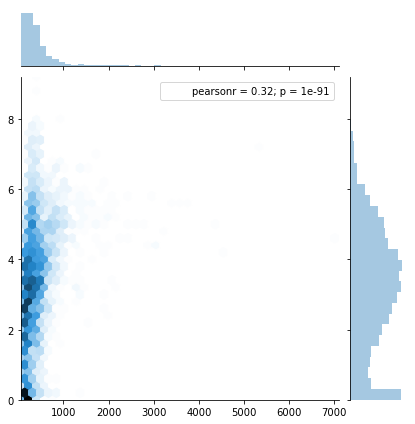

In [30]:
sns.jointplot(lenghts_test, logloss_test, kind="hex")